In [1]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
import keras.optimizers
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import pandas as pd

np.random.seed(7)
maxcol = pd.Series(data={"phi":3.1415,"phie":3.1415,"eta":0.93525,"etae":0.93525,"pt":139.5,"charge":1.0},index=['phi','phie','eta','etae','pt','charge'])
maxout = pd.Series(data={"dphi":1.34265,"tpt":124.286,"teta":0.96229,"tphi":3.14159},index=['dphi','tpt','teta','tphi'])
b2,c2,d2=(0.0008252164922136285, 0.008756475219523592, 1.034524926512658)

/Applications/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataset3 = pd.read_hdf("scout_325099.hd5", 'scout')
dataset3['charge']=dataset3['charge'].apply(lambda x: -x)# fix the charge due to bug in the unpacking -- now fixed

In [3]:
dataset3.shape

(29032272, 8)

In [4]:
modeldphi = load_model('noptcut_modeldphi_tight.h5')
modeleta = load_model('noptcut_modeleta_tight.h5')
modelpt = load_model('noptcut_modelptall_tight.h5')

In [5]:
inputs=['phi','phie','eta','etae','pt','charge']





In [6]:
dataset3['ptcorr']=dataset3['pt'].apply(lambda x: x/( b2*x**2 + c2*x + d2) if x < 30 else x)
X=dataset3
#X/=maxcol
#pt = modelpt.predict(X)
#X*=maxcol
#pt.reshape(pt.shape[0])
#dataset3['ptcorr']=pt*maxout.tpt

In [7]:
X[inputs]/=maxcol
dphi = modeldphi.predict(X[inputs])
X[inputs]*=maxcol

In [8]:
dphi=dphi.reshape(dphi.shape[0])

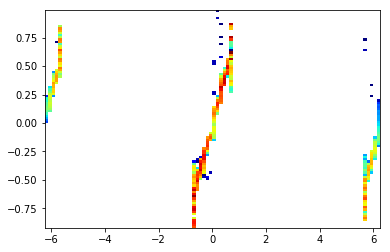

In [9]:
temp=plt.hist2d(X.phi-X.phie,dphi,100,cmap=plt.cm.jet,norm=matplotlib.colors.LogNorm())

In [10]:
print X.shape, dataset3.shape

(29032272, 9) (29032272, 9)


In [11]:
dphi *= maxout.dphi
X[inputs]/=maxcol
eta = modeleta.predict(X[inputs])
X[inputs]*=maxcol
eta = eta.reshape(eta.shape[0])
eta *= maxout.teta
theta=2.*np.arctan(np.exp(-1.*eta))

phi = X.phi-dphi
phi[phi>math.pi]=-2.*math.pi+phi[phi>math.pi]
phi[phi<-1.*math.pi]=2.*math.pi-phi[phi<-1.*math.pi]

In [12]:
px=X.ptcorr*np.cos(phi)
py=X.ptcorr*np.sin(phi)
pz=X.ptcorr/np.tan(theta)
E=np.sqrt(px*px+py*py+pz*pz+0.01)

In [13]:
pairds = pd.DataFrame(data=list(zip(dataset3.bx[0::2],dataset3.phi[0::2],dataset3.phie[0::2],dataset3.eta[0::2],
                                    dataset3.etae[0::2],dataset3.pt[0::2],dataset3.charge[0::2],dataset3.ptcorr[0::2],
                                    E[0::2],px[0::2],py[0::2],pz[0::2],
                                    dataset3.phi[1::2],dataset3.phie[1::2],dataset3.eta[1::2],dataset3.etae[1::2],
                                    dataset3.pt[1::2],dataset3.charge[1::2],dataset3.ptcorr[1::2],
                                    E[1::2],px[1::2],py[1::2],pz[1::2]
                                   )),
                      columns=['bx','phi1','phie1','eta1','etae1','pt1','charge1','ptcorr1','E1','px1','py1','pz1',
                               'phi2','phie2','eta2','etae2','pt2','charge2','ptcorr2','E2','px2','py2','pz2'])


In [14]:
pairds=pairds.assign(mass = lambda x: np.sqrt((x.E1+x.E2)**2-(x.px1+x.px2)**2-(x.py1+x.py2)**2-(x.pz1+x.pz2)**2))

In [15]:
pairds=pairds[pairds.eta1>-1.]

In [16]:
pairds=pairds[pairds.eta2>-1.]

In [17]:
pairds=pairds[pairds.pt1>2.5]
pairds=pairds[pairds.pt2>2.5]
pairds=pairds[pairds.phi1-pairds.phi2>.05]

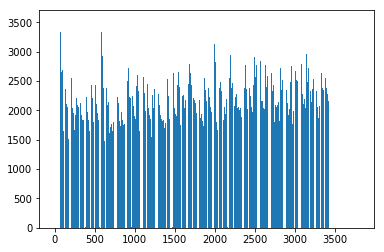

In [18]:
a=plt.hist(pairds.bx,3800,range=(0.,3800.))

In [19]:
onbx=a[0]>1000

In [20]:
pairdsonbx=pairds[onbx[pairds.bx.astype(int)]]

In [21]:
pairdsonbx.shape

(5614033, 24)

In [22]:
offbx = np.logical_not(onbx)

In [23]:
pairdsoffbx=pairds[offbx[pairds.bx.astype(int)]]

In [24]:
pairdsoffbx.shape

(2492, 24)

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.000e+00, 1.000e+00, 2.000e+00, ..., 3.798e+03, 3.799e+03,
        3.800e+03]),
 <a list of 3800 Patch objects>)

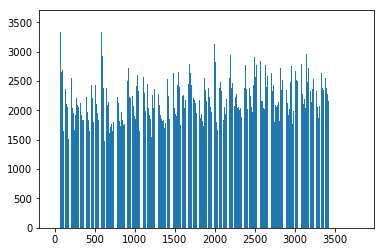

In [25]:
plt.hist(pairdsonbx.bx,3800,range=(0.,3800.))

(array([0., 3., 1., ..., 0., 0., 0.]),
 array([0.000e+00, 1.000e+00, 2.000e+00, ..., 3.798e+03, 3.799e+03,
        3.800e+03]),
 <a list of 3800 Patch objects>)

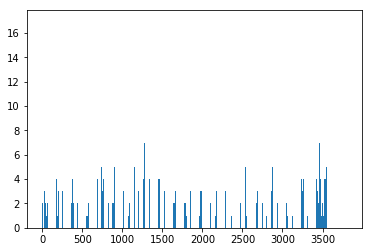

In [26]:

plt.hist(pairdsoffbx.bx,3800,range=(0.,3800.))

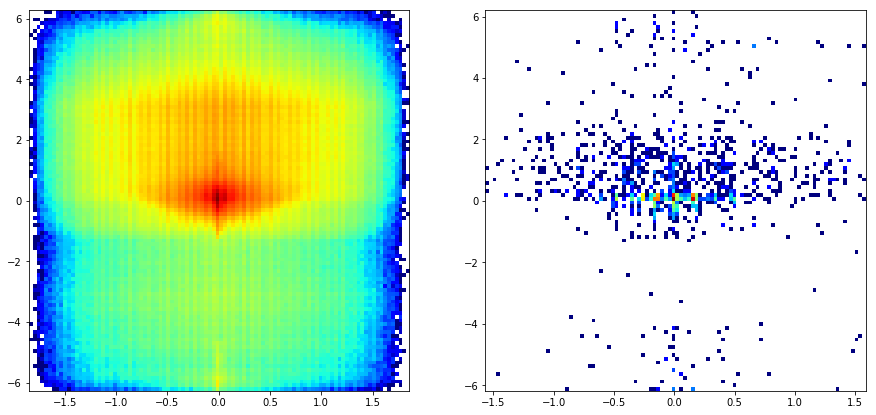

In [27]:
p,ax=plt.subplots(1,2,figsize=(15,7))
tmp=ax[0].hist2d(pairdsonbx.etae1-pairdsonbx.etae2,pairdsonbx.phie1-pairdsonbx.phie2,100,cmap=plt.cm.jet,norm=matplotlib.colors.LogNorm())
tmp=ax[1].hist2d(pairdsoffbx.etae1-pairdsoffbx.etae2,pairdsoffbx.phie1-pairdsoffbx.phie2,100,cmap=plt.cm.jet,norm=matplotlib.colors.LogNorm())

In [28]:
pdonOS=pairdsonbx[pairdsonbx.charge1*pairdsonbx.charge2<0]
pdonSS=pairdsonbx[pairdsonbx.charge1*pairdsonbx.charge2>0]

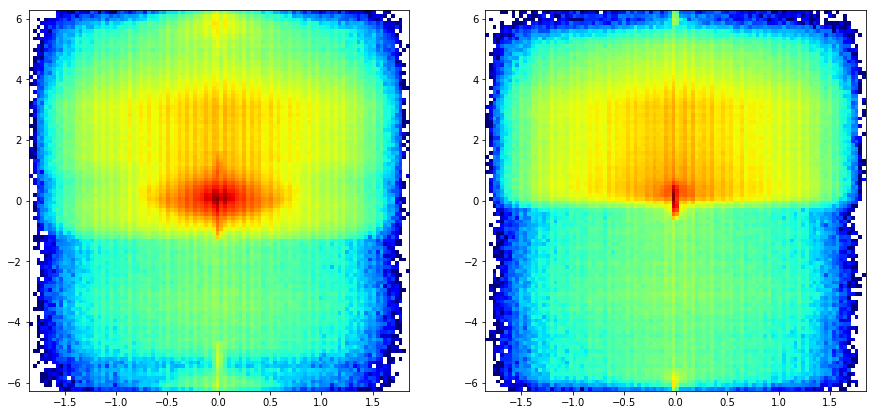

In [29]:
p,ax=plt.subplots(1,2,figsize=(15,7))
tmp=ax[0].hist2d(pdonOS.etae1-pdonOS.etae2,pdonOS.phie1-pdonOS.phie2,100,cmap=plt.cm.jet,norm=matplotlib.colors.LogNorm())
tmp=ax[1].hist2d(pdonSS.etae1-pdonSS.etae2,pdonSS.phie1-pdonSS.phie2,100,cmap=plt.cm.jet,norm=matplotlib.colors.LogNorm())

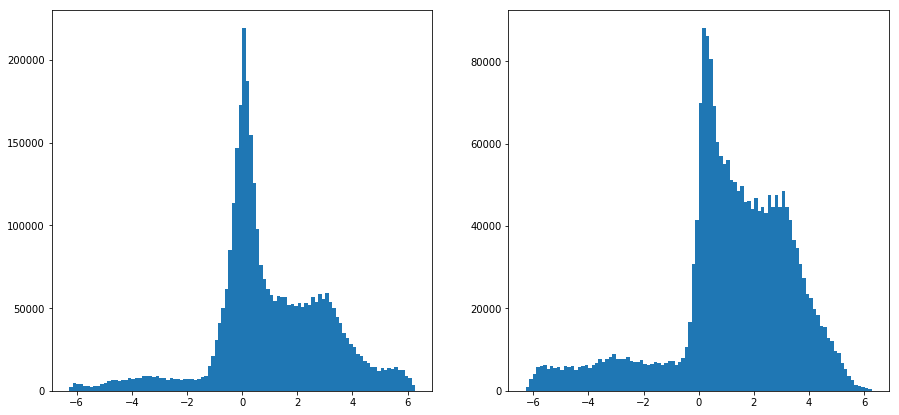

In [30]:
p,ax=plt.subplots(1,2,figsize=(15,7))
tmp=ax[0].hist(pdonOS.phie1-pdonOS.phie2,100)
tmp=ax[1].hist(pdonSS.phie1-pdonSS.phie2,100)

In [31]:
print pdonOS.shape,pdonSS.shape

(3452823, 24) (2161210, 24)


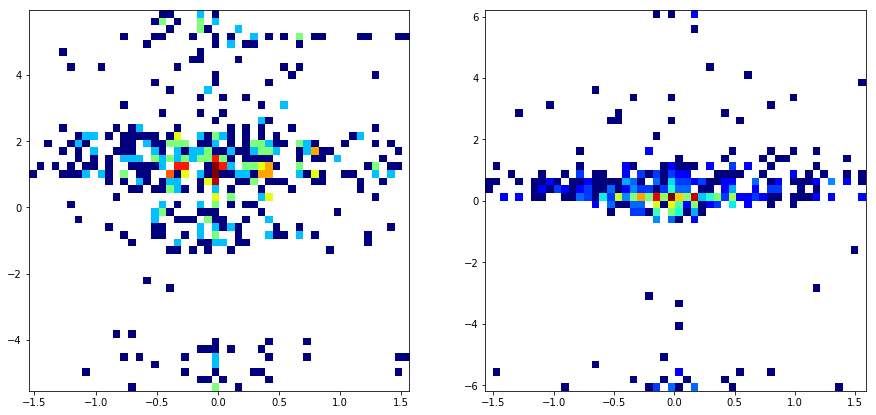

In [32]:
pdoffOS=pairdsoffbx[pairdsoffbx.charge1*pairdsoffbx.charge2<0]
pdoffSS=pairdsoffbx[pairdsoffbx.charge1*pairdsoffbx.charge2>0]
p,ax=plt.subplots(1,2,figsize=(15,7))
tmp=ax[0].hist2d(pdoffOS.etae1-pdoffOS.etae2,pdoffOS.phie1-pdoffOS.phie2,50,cmap=plt.cm.jet,norm=matplotlib.colors.LogNorm())
tmp=ax[1].hist2d(pdoffSS.etae1-pdoffSS.etae2,pdoffSS.phie1-pdoffSS.phie2,50,cmap=plt.cm.jet,norm=matplotlib.colors.LogNorm())

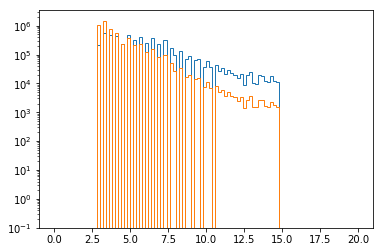

In [33]:
temp=plt.hist(pairds.ptcorr1,100,histtype='step',fill=False,log=True,range=(0,20))
temp=plt.hist(pairds.ptcorr2,100,histtype='step',fill=False,log=True,range=(0,20))

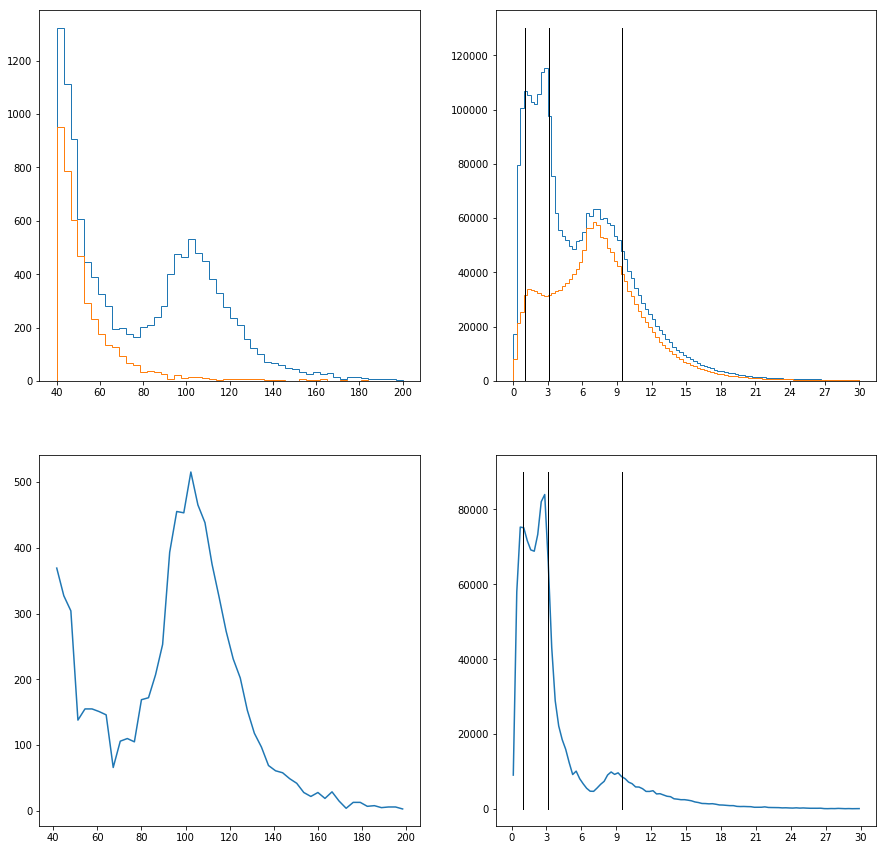

In [34]:
import matplotlib.ticker as ticker
ptcut=3
nbinsx=100
nbinsxlarge=50
ptcutOS = pdonOS[pdonOS.ptcorr1>ptcut]
ptcutOS = ptcutOS[ptcutOS.ptcorr2>ptcut]
ptcutSS = pdonSS[pdonSS.ptcorr1>ptcut]
ptcutSS = ptcutSS[ptcutSS.ptcorr2>ptcut]
p,ax = plt.subplots(2,2,figsize=(15,15))
ax[0][0].xaxis.set_major_locator(ticker.MultipleLocator(20))
ax[0][1].xaxis.set_major_locator(ticker.MultipleLocator(3.))
#ax[2].set_xticks(ax[0].get_xticks()[::2])
#ax[3].set_xticks(ax[1].get_xticks()[::2])
al=ax[0][0].hist(ptcutOS.mass[(ptcutOS.phi1!=ptcutOS.phi2)],nbinsxlarge,range=(40.,200.),histtype='step',fill=False)
bl=ax[0][0].hist(ptcutSS.mass[(ptcutSS.phi1!=ptcutSS.phi2)],nbinsxlarge,range=(40.,200.),histtype='step',fill=False)
x0=[(al[1][i]+al[1][i-1])/2 for i in range(1,nbinsxlarge+1,1)]
a=ax[0][1].hist(ptcutOS.mass[(ptcutOS.phi1!=ptcutOS.phi2)],nbinsx,range=(0.,30.),histtype='step',fill=False)
b=ax[0][1].hist(ptcutSS.mass[(ptcutSS.phi1!=ptcutSS.phi2)],nbinsx,range=(0.,30.),histtype='step',fill=False)
x1=[(a[1][i]+a[1][i-1])/2 for i in range(1,nbinsx+1,1)]
c=a[0]-b[0]
cl=al[0]-bl[0]
ax[1][0].plot(x0,cl)
ax[1][1].plot(x1,c)
ax[1][1].xaxis.set_major_locator(ticker.MultipleLocator(3.))
ax[0][1].plot([3.09, 3.09], [0, 130000], 'k-', lw=1)
ax[0][1].plot([1.02, 1.02], [0, 130000], 'k-', lw=1)
ax[0][1].plot([9.46, 9.46], [0, 130000], 'k-', lw=1)
ax[1][1].plot([3.09, 3.09], [0, 90000], 'k-', lw=1)
ax[1][1].plot([1.02, 1.02], [0, 90000], 'k-', lw=1)
ax[1][1].plot([9.46, 9.46], [0, 90000], 'k-', lw=1)



In [41]:
np.sum(cl[10:30])

5509.0

(array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-2.784    , -2.7468075, -2.709615 , -2.6724225, -2.63523  ,
        -2.5980375, -2.560845 , -2.5236525, -2.48646  , -2.4492675,
        -2.412075 , -2.3748825, -2.33769  , -2.3004975, -2.263305 ,
        -2.2261125, -2.18892  , -2.1517275, -2.114535 , -2.0773425,
        -2.04015  , -2.0029575, -1.965765 , -1.9285725, -1.89138  ,
        -1.8541875, -1.816995 , -1.7798025, -1.74261  , -1.7054175,
        -1.668225 , -1.6310325, -1.59384  , -1.5566475, -1.519455 ,
        -1.4822625, -1.44507  , -1.4078775, -1.370685 , -1.3334925,
        -1.2963   , -1.2591075, -1.221915 , -1.1847225, -1.14753  ,
        -1.1103375, -1.073145 , -1.0359525, -0.99876  , -0.9615675,
        -0.924375 , -0.8871825, -0.84999  , -0.8127975, -0.775605 ,
   

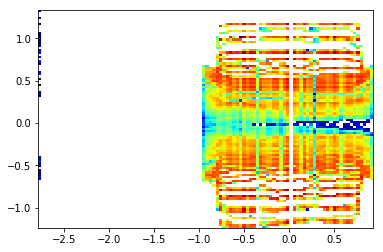

In [35]:
plt.hist2d(X.eta,dphi,100,cmap=plt.cm.jet,norm=matplotlib.colors.LogNorm())

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0., 208174.,      0., 536880.,      0.,      0., 472011.,
             0., 443064.,      0.,      0., 239438.,      0., 477308.,
             0.,      0., 307802.,      0., 412264.,      0.,      0.,
        255012.,      0., 375349.,      0.,      0., 222427.,      0.,
        322501.,      0.,      0., 173577.,      0.,  98910.,      0.,
             0., 133756.,      0.,  69278.,      0.,      0.,  86434.,
             0.,  63229.,      0.,      0.,  72716.,      0.,  37668.,
             0.,      0.,  57441.,      0.,  36309.,      0.,      0.,
         44548.,      0.,  27310.,      0.,      0.,  34190.,      0.,
         21211.,      0.,      0.,  29840.,      0.,  22549.,      0.,
             0.,  20075.,      0.,  15670.,      0.,      0.,  21906.,
             0.,   8758.,      0.,      0.,  19368.,      0.,   6999.,
      

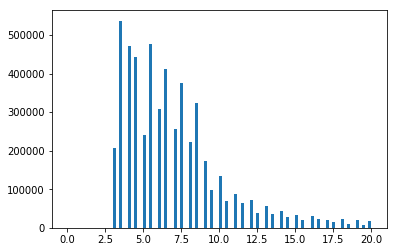

In [36]:
plt.hist(pairds.pt1,100,range=(0,20))

(array([[  0.,   0.,   1., ...,  25.,   1.,   0.],
        [  0.,   0.,   1., ...,  37.,   6.,   0.],
        [  0.,   1.,  11., ..., 598.,  67.,  11.],
        ...,
        [  1.,   1.,   7., ..., 367.,  63.,   4.],
        [  0.,   0.,   0., ...,  90.,   7.,   1.],
        [  0.,   0.,   1., ...,   9.,   0.,   0.]]),
 array([-9.35250000e-01, -9.16545000e-01, -8.97840000e-01, -8.79135000e-01,
        -8.60430000e-01, -8.41725000e-01, -8.23020000e-01, -8.04315000e-01,
        -7.85610000e-01, -7.66905000e-01, -7.48200000e-01, -7.29495000e-01,
        -7.10790000e-01, -6.92085000e-01, -6.73380000e-01, -6.54675000e-01,
        -6.35970000e-01, -6.17265000e-01, -5.98560000e-01, -5.79855000e-01,
        -5.61150000e-01, -5.42445000e-01, -5.23740000e-01, -5.05035000e-01,
        -4.86330000e-01, -4.67625000e-01, -4.48920000e-01, -4.30215000e-01,
        -4.11510000e-01, -3.92805000e-01, -3.74100000e-01, -3.55395000e-01,
        -3.36690000e-01, -3.17985000e-01, -2.99280000e-01, -2.80575000e

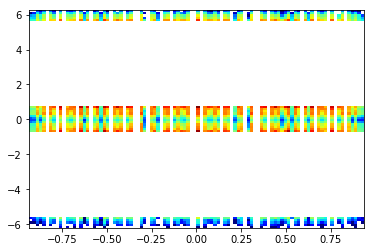

In [37]:
plt.hist2d(pairds.eta2,pairds.phie2-pairds.phi2,100,cmap=plt.cm.jet,norm=matplotlib.colors.LogNorm())

In [38]:
from keras.utils.vis_utils import plot_model
plot_model(modeldphi, to_file='modeldphi_plot.png', show_shapes=True, show_layer_names=True)

In [39]:
pairds.to_hdf('pairs_325099.hd5','scoutpairs',complevel=9)